In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
import xlsxwriter 
%matplotlib inline
import import_ipynb
import functions_NGD
import random

importing Jupyter notebook from functions_NGD.ipynb


## Load data / find cross-correlation of ganglion cell output

importing Jupyter notebook from NGDfunc.ipynb


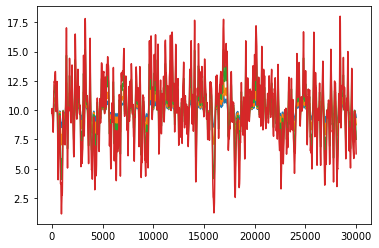

In [2]:
import os
os.chdir('F:/我的雲端硬碟/Retina exp/python code/functions')
import import_ipynb
import NGDfunc

dt=0.01
tau_ou=1
fc=1
T_ou=300
nsteps_ou=int(T_ou/dt)
mid_pos=500
randseed = np.random.normal(0, 50, nsteps_ou)
time_ou,x_ou=NGDfunc.OU(T_ou,tau_ou,'no',dt,randseed)
time_ou,x_lpou=NGDfunc.OU(T_ou,tau_ou,fc,dt,randseed)

amp=[0.5,1,2,3]
mean=10
x_set=[]
# x_set.append(x_lpou/np.std(x_lpou)*amp[3]+20)
for i in range(len(amp)):
    x_set.append(x_lpou/np.std(x_lpou)*amp[i]+mean)
    plt.plot(x_set[i])


## NGD output

In [3]:
alpha,beta,K,g=6,1.6,22,10 # channel 39
# alpha,beta,K,g=8,1.4,37,10 # channel 47
y_set=[functions_NGD.NGD(x_set[j],dt,alpha,beta,K,g,1)[0] for j in range(np.size(x_set,0))] 
z_set=[functions_NGD.NGD(x_set[j],dt,alpha,beta,K,g,1)[1] for j in range(np.size(x_set,0))] 

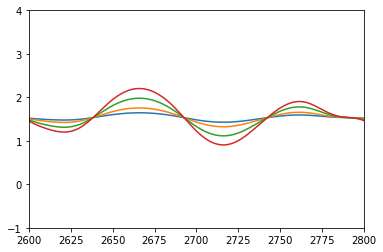

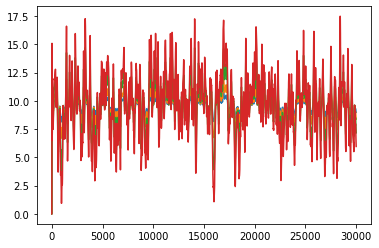

In [4]:
for i in range(4):
    plt.plot(y_set[i])
plt.ylim(-1,4)
plt.xlim(2600,2800)
plt.show()
for i in range(4):
    plt.plot(z_set[i])
# plt.ylim(-1,4)
# plt.xlim(2000,4000)

## Adding horizontal feedback to NGD output (y+z)

### MI and cross correlation of B

[0.87 0.9 ]


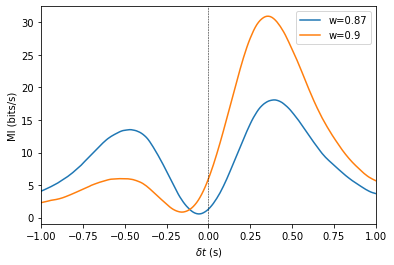

In [11]:
# wy=np.linspace(0.8,1,5)
wy=np.array([0.87,0.9])
# wy=0.9
print(wy)
# wy=[]
iamp=3
x=x_set[iamp]
y=y_set[iamp]
z=z_set[iamp]
B=[wy[k]*y-(1-wy[k])*z for k in range(len(wy))]
MIxyz=[[] for i in range(len(B))]
corrxyz=[[] for i in range(len(B))]
for k in range(len(B)):
    tsxyz,MIxyz[k]=functions_NGD.MI(functions_NGD.EqualState(x,8),functions_NGD.EqualState(B[k],8),dt,[-2,2])
    tc,corrxyz[k]=functions_NGD.xcorr_quick(x,B[k],5,0.01)
# color2=['k','r']
for i in range(len(B)):
    plt.plot(tsxyz,MIxyz[i],label='w='+str(round(wy[i],3)))
plt.legend()
plt.xlim(-1,1)
plt.ylabel('MI (bits/s)')
plt.xlabel('$\delta t$ (s)')
plt.axvline(x=0,c='k',linewidth=0.5,linestyle='dashed')
# plt.grid()
# find prediction horizon

# for i in range(len(MIxyz)):
#     plt.plot(tsxyz[np.argmax(MIxyz[i])],max(MIxyz[i]),'o')
# plt.show()

# plt.savefig('F:/我的雲端硬碟/Retina exp/Poster present/Sfn poster 20210111/figure/MI_fb_ff.png',dpi=300)

# for i in range(len(B)):
#     plt.plot(tc,corrxyz[i])
# plt.xlim(-5,5)
# plt.grid()

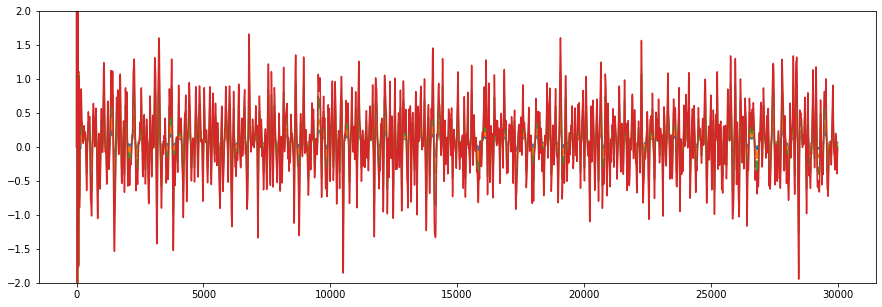

In [12]:
f1,ax1=plt.subplots(figsize=(15,5))
B_set=[0 for k in range(len(x_set))]
for i in range(len(x_set)):
    B_set[i]=y_set[i]*0.87-z_set[i]*0.13
    plt.plot(B_set[i])
    plt.ylim(-2,2)

### generate poisson spikes

In [17]:
# poisson as a function
# ON cell: onoff=0
# OFF cell: onoff=1
def poisson(r_in,thr,onoff):
    rtemp=(-1)**onoff*(r_in-thr)
    rtemp[rtemp<0]=0
    rtemp=rtemp/(np.sum(rtemp[100:]))*10*len(rtemp[100:]) # set the mean firing rate as 5 hz
    tempspikes=np.zeros(len(rtemp))
    for step in range(len(rtemp)):
        if random.random()<rtemp[step]*dt:
            tempspikes[step]=1
        else:
            tempspikes[step]=0
    return tempspikes

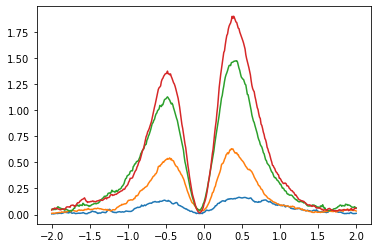

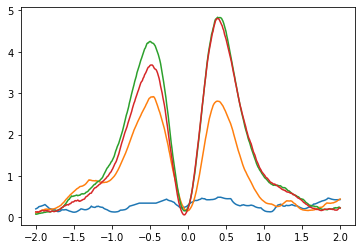

In [18]:
from NGDfunc import MI
from NGDfunc import EqualState
spike_on=[0 for i in range(len(x_set))]
spike_off=[0 for i in range(len(x_set))]
th=-0.2
f2,ax2=plt.subplots()
f3,ax3=plt.subplots()
for j in range(len(x_set)):
    spike_on=poisson(B_set[j],th,0)
    spike_off=poisson(B_set[j],th,1)
    tl,MI_spike_on=MI(EqualState(x_set[j],8),spike_on,dt,[-2,2])
    tl,MI_spike_off=MI(EqualState(x_set[j],8),spike_off,dt,[-2,2])
    ax2.plot(tl,MI_spike_on)
    ax3.plot(tl,MI_spike_off)